
════════════════════════════════════════════════════════════════════════════════
                       LEVER Effective Hamiltonian Study                        
════════════════════════════════════════════════════════════════════════════════

System:     N2_STO3G
Orbitals:   10
Electrons:  (7α, 7β)
FCI Space:  14,400 determinants

────────────────────────────────────────────────────────────────────────────────
Solving FCI Reference
────────────────────────────────────────────────────────────────────────────────
E_FCI = -107.438020369575 Ha

────────────────────────────────────────────────────────────────────────────────
Convergence Study: N2_STO3G
────────────────────────────────────────────────────────────────────────────────
   k    |C|    ΔE_sCI (mHa)    ΔE_H̃ (mHa)
-----------------------------------------
  50   6302          0.0000         0.0000
  75   6421          0.0000         0.0000
 100   8354          0.0000         0.0000
 150  11041          0.0000         0.0000
 200

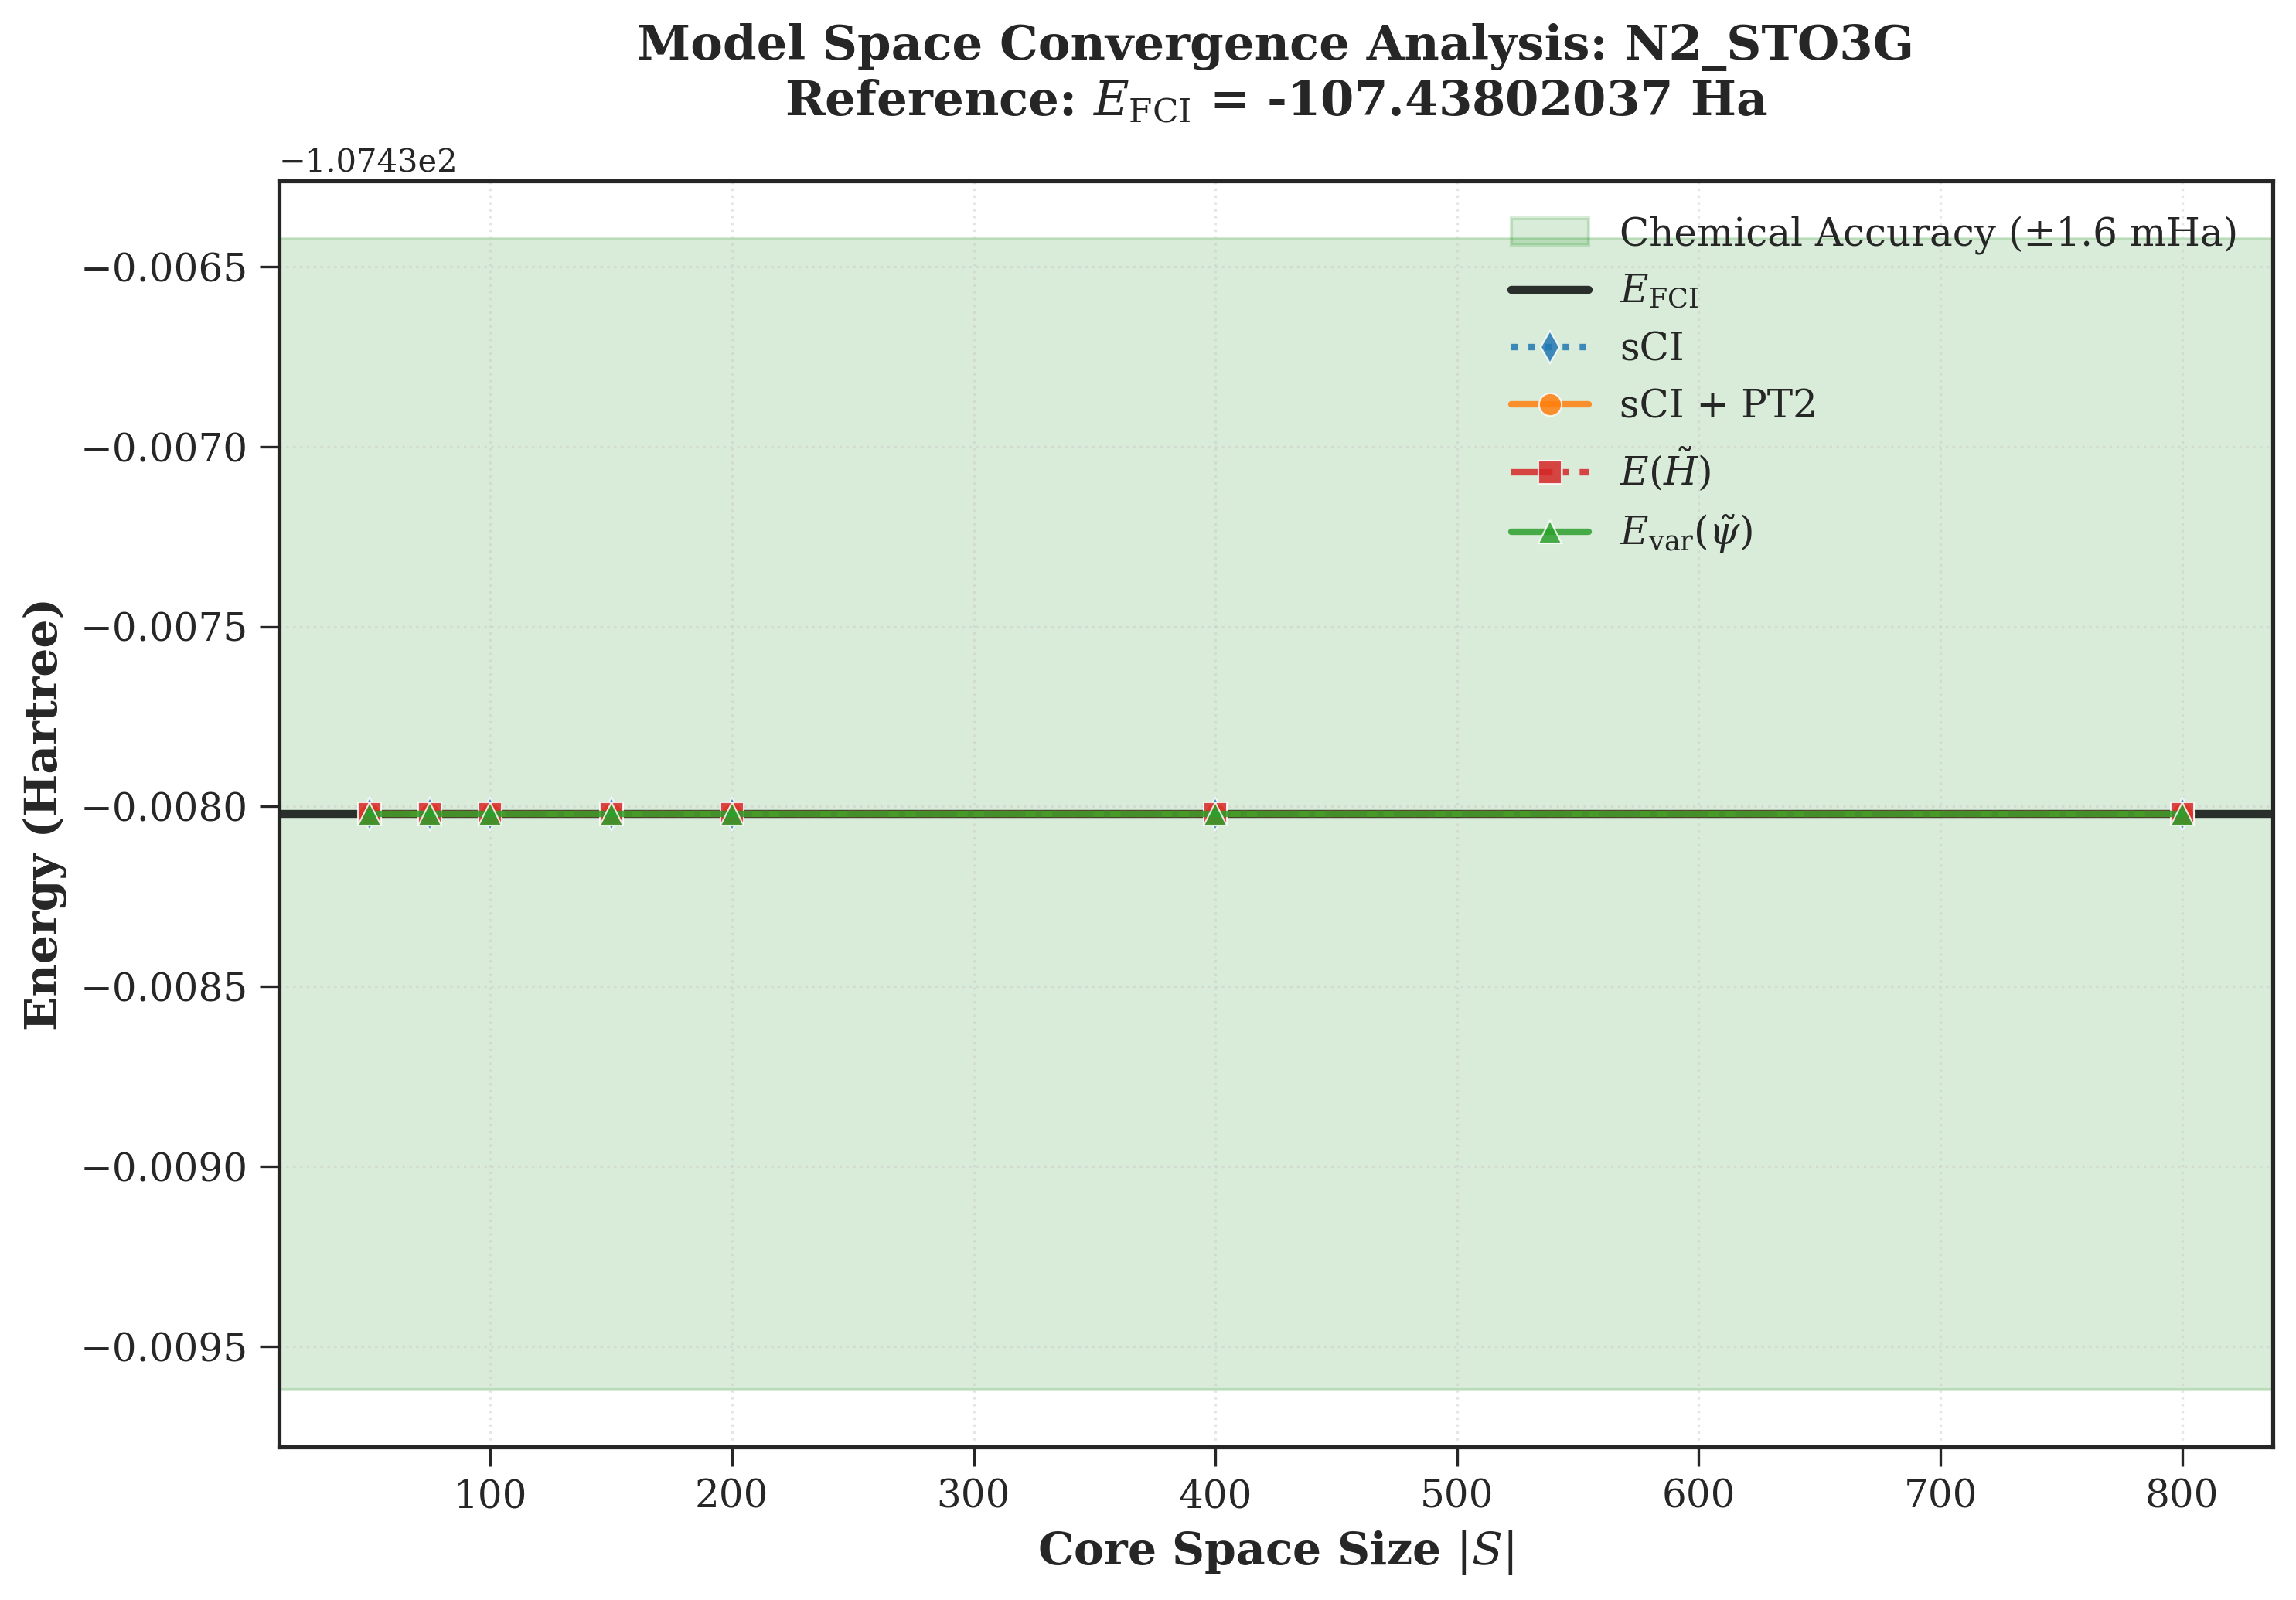

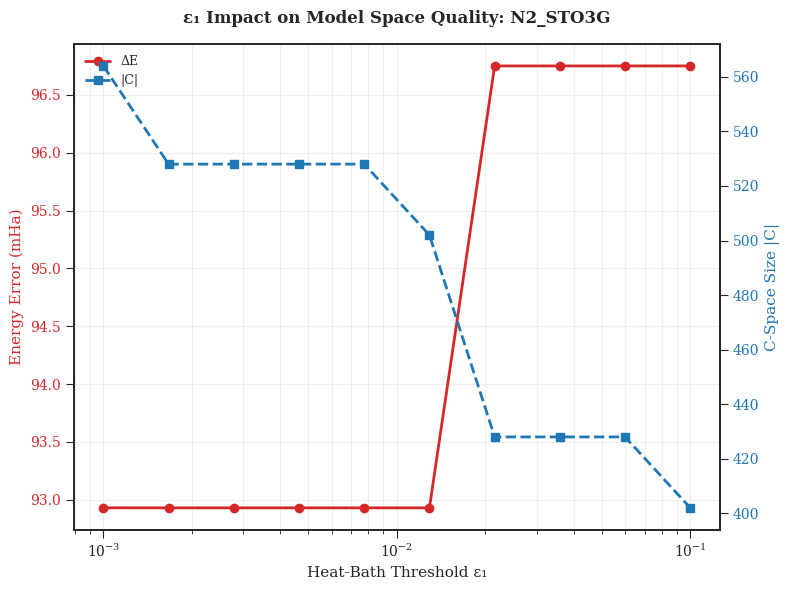


════════════════════════════════════════════════════════════════════════════════
                                 Study Complete                                 
════════════════════════════════════════════════════════════════════════════════



In [28]:
# Copyright 2025 The LEVER Authors - All rights reserved.
# SPDX-License-Identifier: Apache-2.0

"""
Effective Hamiltonian convergence study.

Analyzes model space approximation quality vs core space size by comparing:
- sCI: Variational energy within the S-space
- sCI+PT2: Selected CI with Epstein-Nesbet perturbation theory
- E(H̃): Model Hamiltonian diagonalization energy
- E_var(ψ̃): Variational energy of model space eigenvector

File: examples/study_effective_ham.py
Author: Zheng (Alex) Che, email: wsmxcz@gmail.com
Date: January, 2025
"""

from __future__ import annotations

from dataclasses import dataclass, field
from pathlib import Path
from typing import NamedTuple

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

import lever


# --- System Configuration ---

SYSTEM_NAME = "N2_STO3G"
FCIDUMP_PATH = Path("../benchmark/FCIDUMP/N2_sto3g_10.0.FCIDUMP")
NUM_ORBITALS = 10
NUM_ALPHA = 7
NUM_BETA = 7 

K_MAX = 800  # Maximum core space dimension
PT2_DEN_TOL = 1e-12  # Epstein-Nesbet denominator cutoff
HAM_THRESH = 1e-12  # Hamiltonian matrix element threshold
SPARSE_DENSE_CUTOFF = 10  # Dense solver threshold


# --- Data Structures ---

class EigenPair(NamedTuple):
    """Eigenvalue-eigenvector pair from diagonalization."""
    energy: float
    vector: np.ndarray


@dataclass
class ConvergenceResults:
    """Convergence study data storage."""
    k: list[int] = field(default_factory=list)
    size_C: list[int] = field(default_factory=list)
    E_sCI: list[float] = field(default_factory=list)  # Added: Variational energy in S-space (sCI)
    E_sCI_PT2: list[float] = field(default_factory=list)
    E_tilde_H: list[float] = field(default_factory=list)
    E_true_on_psi_tilde: list[float] = field(default_factory=list)


@dataclass
class EpsStudyResults:
    """Heat-bath threshold study data storage."""
    eps1: list[float] = field(default_factory=list)
    size_C: list[int] = field(default_factory=list)
    E_tilde_H: list[float] = field(default_factory=list)


# --- Sparse Matrix Operations ---

def to_sparse(op: lever.HamOp) -> sp.csr_matrix:
    """Convert LEVER HamOp to CSR format for eigensolving."""
    mat = sp.coo_matrix((op.vals, (op.rows, op.cols)), shape=op.shape)
    mat.sum_duplicates()
    return mat.tocsr()


def lowest_eigenpair(matrix: sp.csr_matrix) -> EigenPair:
    """
    Compute ground state via sparse or dense diagonalization.

    Uses dense solver for small matrices (N < 10) for better stability,
    iterative ARPACK solver otherwise.
    """
    if matrix.shape[0] == 0:
        return EigenPair(np.inf, np.array([]))

    if matrix.shape[0] < SPARSE_DENSE_CUTOFF:
        evals, evecs = np.linalg.eigh(matrix.toarray())
        return EigenPair(evals[0], evecs[:, 0])

    evals, evecs = spla.eigsh(matrix, k=1, which='SA', tol=1e-15, ncv=200, maxiter=3000)
    return EigenPair(evals[0], evecs[:, 0])


# --- Energy Estimators ---

def compute_pt2_correction(
    E_var: float,
    psi_S: np.ndarray,
    ham_sc: lever.HamOp,
    H_diag_C: np.ndarray,
) -> float:
    """
    Epstein-Nesbet second-order perturbation theory correction:

    E₂ = Σ_k |⟨k|H|ψ_S⟩|² / (E_var - H_kk)

    where k runs over external space C.
    """
    if ham_sc.nnz == 0:
        return 0.0

    # Construct H_CS = H_SC^† and compute coupling strengths
    H_CS = to_sparse(lever.HamOp(
        rows=ham_sc.cols,
        cols=ham_sc.rows,
        vals=np.conj(ham_sc.vals),
        shape=(ham_sc.shape[1], ham_sc.shape[0]),
    ))
    numerator = H_CS @ psi_S
    denominator = E_var - H_diag_C

    # Regularized sum over energetically accessible states
    mask = np.abs(denominator) > PT2_DEN_TOL
    if not np.any(mask):
        return 0.0

    return float(np.sum(np.abs(numerator[mask])**2 / denominator[mask]))


def build_model_hamiltonian(
    ham_ss: lever.HamOp,
    ham_sc: lever.HamOp,
    H_diag_C: np.ndarray,
) -> sp.csr_matrix:
    """
    Construct effective Hamiltonian in model space T = S ⊕ C:

    H̃ = ⎡ H_SS    H_SC   ⎤
        ⎣ H_CS  diag(H_C)⎦

    Decouples external states by dropping off-diagonal H_CC terms.
    """
    if ham_sc.shape[1] == 0:
        return to_sparse(ham_ss)
  
    shifted_diag_C = H_diag_C + 2.0
  
    return sp.bmat([
        [to_sparse(ham_ss), to_sparse(ham_sc)],
        [to_sparse(ham_sc).T.conj(), sp.diags(shifted_diag_C)]
    ], format='csr')


def compute_true_expectation(
    psi_tilde: np.ndarray,
    space: lever.SpaceRep,
    int_ctx: lever.IntCtx,
) -> float:
    """
    Compute exact ⟨ψ̃|H_full|ψ̃⟩ for validation.

    Builds full Hamiltonian H_TT on combined space T = S ∪ C
    without approximations.
    """
    T_dets = np.vstack([space.s_dets, space.c_dets])

    ham_tt, _, _ = lever.get_ham_proxy(
        T_dets,
        int_ctx=int_ctx,
        n_orbitals=NUM_ORBITALS,
        use_heatbath=False,
        thresh=HAM_THRESH,
    )
    H_TT = to_sparse(ham_tt)

    return float(np.real(np.vdot(psi_tilde, H_TT @ psi_tilde) / 
                         np.vdot(psi_tilde, psi_tilde)))


# --- Convergence Studies ---

def convergence_study(
    int_ctx: lever.IntCtx,
    fci_dets: np.ndarray,
    E_fci: float,
    psi_fci: np.ndarray,
) -> ConvergenceResults:
    """
    Analyze energy convergence with increasing core space size.

    Selects S-space determinants by FCI coefficient magnitude and tracks
    four energy estimators as |S| grows.
    """
    print(f"\n{'─'*80}\nConvergence Study: {SYSTEM_NAME}\n{'─'*80}")

    ranking = np.argsort(-np.abs(psi_fci))
    e_nuc = int_ctx.get_e_nuc()

    k_points = [50, 75, 100, 150, 200, 400, 800]
    ks = [k for k in k_points if k <= min(len(fci_dets), K_MAX)]

    results = ConvergenceResults()

    # Updated print header to include sCI error
    print(f"{'k':>4} {'|C|':>6} {'ΔE_sCI (mHa)':>15} {'ΔE_H̃ (mHa)':>14}")
    print(f"{'-'*41}")

    for k in ks:
        S_dets = fci_dets[ranking[:k]]
    
        # Build Hamiltonian operators
        ham_ss, ham_sc, space = lever.get_ham_proxy(
            S_dets, int_ctx=int_ctx, n_orbitals=NUM_ORBITALS,
            use_heatbath=False, thresh=HAM_THRESH
        )
    
        # Compute energy estimates
        ep_var = lowest_eigenpair(to_sparse(ham_ss)) # sCI eigenpair
        pt2 = compute_pt2_correction(ep_var.energy, ep_var.vector, ham_sc, space.H_diag_C)
    
        H_tilde = build_model_hamiltonian(ham_ss, ham_sc, space.H_diag_C)
        ep_tilde = lowest_eigenpair(H_tilde)
    
        E_true_elec = compute_true_expectation(ep_tilde.vector, space, int_ctx)
    
        # Record results, including the sCI energy
        results.k.append(k)
        results.size_C.append(space.size_C)
        results.E_sCI.append(ep_var.energy + e_nuc)
        results.E_sCI_PT2.append(ep_var.energy + pt2 + e_nuc)
        results.E_tilde_H.append(ep_tilde.energy + e_nuc)
        results.E_true_on_psi_tilde.append(E_true_elec + e_nuc)
    
        # Calculate and print errors for key estimators
        err_sCI_mHa = (results.E_sCI[-1] - E_fci) * 1000
        err_H_tilde_mHa = (results.E_tilde_H[-1] - E_fci) * 1000
        print(f"{k:4d} {space.size_C:6d} {err_sCI_mHa:15.4f} {err_H_tilde_mHa:14.4f}")

    return results


def eps_threshold_study(
    int_ctx: lever.IntCtx,
    fci_dets: np.ndarray,
    E_fci: float,
    psi_fci: np.ndarray,
) -> EpsStudyResults:
    """
    Study heat-bath screening threshold ε₁ effect on C-space size.

    Fixes |S| = 100 and sweeps ε₁ to analyze accuracy-efficiency tradeoff
    in external space construction.
    """
    print(f"\n{'─'*80}\nHeat-Bath Threshold Study: {SYSTEM_NAME}\n{'─'*80}")

    e_nuc = int_ctx.get_e_nuc()
    int_ctx.hb_prepare(threshold=1e-10)

    k = min(len(fci_dets), 10)
    S_dets = fci_dets[np.argsort(-np.abs(psi_fci))[:k]]
    print(f"Fixed S-space: k = {k}\n")

    eps_values = np.logspace(-3, -1, 10)
    results = EpsStudyResults()

    print(f"{'ε₁':>12} {'|C|':>6} {'ΔE (mHa)':>12}")
    print(f"{'-'*36}")

    for eps1 in eps_values:
        ham_ss, ham_sc, space = lever.get_ham_proxy(
            S_dets, int_ctx=int_ctx, n_orbitals=NUM_ORBITALS,
            use_heatbath=True, eps1=eps1, thresh=HAM_THRESH
        )
    
        H_tilde = build_model_hamiltonian(ham_ss, ham_sc, space.H_diag_C)
        ep = lowest_eigenpair(H_tilde)
    
        E_total = ep.energy + e_nuc
        results.eps1.append(eps1)
        results.size_C.append(space.size_C)
        results.E_tilde_H.append(E_total)
    
        err_mHa = (E_total - E_fci) * 1000
        print(f"{eps1:12.2e} {space.size_C:6d} {err_mHa:12.4f}")

    return results


# --- Visualization ---

def plot_convergence(results: ConvergenceResults, E_fci: float) -> None:
    """
    Visualize energy convergence with core space size expansion.
  
    Plots four energy estimators against |S| with chemical accuracy
    reference band and statistical analysis.
  
    Args:
        results: Convergence study data containing energies vs core size
        E_fci: Full CI reference energy in Hartree
    """
    plt.style.use('seaborn-v0_8-ticks')
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
  
    fig, ax = plt.subplots(figsize=(10, 7), dpi=300)
  
    colors = plt.get_cmap('tab10').colors
  
    # Chemical accuracy band (±1.6 mHa)
    chemical_accuracy = 1.6e-3  # 1.6 mHa in Hartree
    ax.axhspan(
        E_fci - chemical_accuracy, E_fci + chemical_accuracy,
        alpha=0.15, color='green', zorder=0,
        label='Chemical Accuracy (±1.6 mHa)'
    )
  
    # FCI reference line
    ax.axhline(
        E_fci, color='black', linestyle='-', linewidth=2.5,
        label=r'$E_\mathrm{FCI}$', zorder=2, alpha=0.8
    )
  
    # Energy estimator curves
    # Added: Plot for sCI variational energy
    ax.plot(
        results.k, results.E_sCI, 'd:',
        color=colors[0], markersize=7, linewidth=2, alpha=0.85,
        label=r'sCI', markeredgewidth=0.5, markeredgecolor='white'
    )
    ax.plot(
        results.k, results.E_sCI_PT2, 'o-',
        color=colors[1], markersize=7, linewidth=2, alpha=0.85,
        label=r'sCI + PT2', markeredgewidth=0.5, markeredgecolor='white'
    )
    ax.plot(
        results.k, results.E_tilde_H, 's-.',
        color=colors[3], markersize=7, linewidth=2, alpha=0.85,
        label=r'$E(\tilde{H})$', markeredgewidth=0.5, markeredgecolor='white'
    )
    ax.plot(
        results.k, results.E_true_on_psi_tilde, '^-',
        color=colors[2], markersize=7, linewidth=2, alpha=0.85,
        label=r'$E_\mathrm{var}(\tilde{\psi})$',
        markeredgewidth=0.5, markeredgecolor='white'
    )
  
    # Axis labels and title
    ax.set_xlabel(r'Core Space Size $|S|$', fontsize=14, fontweight='bold')
    ax.set_ylabel('Energy (Hartree)', fontsize=14, fontweight='bold')
    ax.set_title(
        f'Model Space Convergence Analysis: {SYSTEM_NAME}\n'
        f'Reference: $E_\\mathrm{{FCI}}$ = {E_fci:.8f} Ha',
        fontsize=15, fontweight='bold', pad=20
    )
  
    # Grid and legend
    ax.grid(True, linestyle=':', linewidth=0.8, alpha=0.5, which='both')
    ax.legend(
        loc='upper right', framealpha=0.95, fontsize=12,
        edgecolor='gray', fancybox=True, shadow=True
    )
    ax.tick_params(axis='both', which='major', labelsize=12)
  
    plt.tight_layout()
    # plt.savefig('convergence_study.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()


def plot_eps_study(results: EpsStudyResults, E_fci: float) -> None:
    """Generate heat-bath threshold sensitivity plot."""
    fig, ax1 = plt.subplots(figsize=(8, 6))

    errors = (np.array(results.E_tilde_H) - E_fci) * 1000

    ax1.semilogx(results.eps1, errors, 'o-', color='tab:red', 
                 markersize=6, linewidth=2, label='ΔE')
    ax1.set_xlabel('Heat-Bath Threshold ε₁', fontsize=11)
    ax1.set_ylabel('Energy Error (mHa)', fontsize=11, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.grid(True, alpha=0.3, which='both')

    ax2 = ax1.twinx()
    ax2.semilogx(results.eps1, results.size_C, 's--', color='tab:blue',
                 markersize=6, linewidth=2, label='|C|')
    ax2.set_ylabel('C-Space Size |C|', fontsize=11, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title(f'ε₁ Impact on Model Space Quality: {SYSTEM_NAME}', 
              fontsize=12, fontweight='bold', pad=15)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=9)

    fig.tight_layout()
    plt.show()


# --- Main Execution ---

def main() -> None:
    """Run full convergence analysis."""
    print(f"\n{'═'*80}")
    print(f"{'LEVER Effective Hamiltonian Study':^80}")
    print(f"{'═'*80}\n")

    if not FCIDUMP_PATH.exists():
        raise FileNotFoundError(f"FCIDUMP not found: {FCIDUMP_PATH}")

    int_ctx = lever.IntCtx(str(FCIDUMP_PATH), NUM_ORBITALS)
    fci_dets = lever.gen_fci_dets(NUM_ORBITALS, NUM_ALPHA, NUM_BETA)

    print(f"System:     {SYSTEM_NAME}")
    print(f"Orbitals:   {NUM_ORBITALS}")
    print(f"Electrons:  ({NUM_ALPHA}α, {NUM_BETA}β)")
    print(f"FCI Space:  {len(fci_dets):,} determinants")

    # Compute FCI reference
    print(f"\n{'─'*80}\nSolving FCI Reference\n{'─'*80}")
    ham_fci, _, _ = lever.get_ham_proxy(
        fci_dets, int_ctx=int_ctx, n_orbitals=NUM_ORBITALS, use_heatbath=False
    )

    ep_fci = lowest_eigenpair(to_sparse(ham_fci))
    E_fci = ep_fci.energy + int_ctx.get_e_nuc()
    print(f"E_FCI = {E_fci:.12f} Ha")

    # Execute convergence studies
    conv_results = convergence_study(int_ctx, fci_dets, E_fci, ep_fci.vector)
    eps_results = eps_threshold_study(int_ctx, fci_dets, E_fci, ep_fci.vector)

    # Generate visualization
    print(f"\n{'─'*80}\nGenerating Plots\n{'─'*80}")
    plot_convergence(conv_results, E_fci)
    plot_eps_study(eps_results, E_fci)

    print(f"\n{'═'*80}")
    print(f"{'Study Complete':^80}")
    print(f"{'═'*80}\n")


if __name__ == "__main__":
    main()